# NLP - COVID-19 Fake News Classification 

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

## 1. Load Datasets. 

In [2]:
# load the training set
c19_fake_news_df_train = pd.read_csv('train.csv')

# load the testing set
c19_fake_news_df_test = pd.read_csv('test.csv')

In [3]:
# read the first five rows of the training set
c19_fake_news_df_train.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [4]:
c19_fake_news_df_test.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


## 2. Data Preprocessing

#### 2.1 Data Information 

In [5]:
# display the data information on training set
c19_fake_news_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6420 non-null   int64 
 1   tweet   6420 non-null   object
 2   label   6420 non-null   object
dtypes: int64(1), object(2)
memory usage: 150.6+ KB


In [6]:
# display the data information on testing set
c19_fake_news_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2140 non-null   int64 
 1   tweet   2140 non-null   object
 2   label   2140 non-null   object
dtypes: int64(1), object(2)
memory usage: 50.3+ KB


#### 2.2 Missing Data Handling

In [7]:
# check for missing rows data in the training set
c19_fake_news_df_train.isnull().sum()

id       0
tweet    0
label    0
dtype: int64

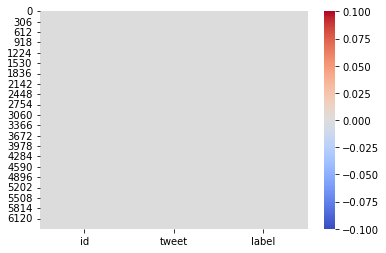

In [8]:
# plot a heatmap to show the presence of missing rows data in the training set
sns.heatmap(c19_fake_news_df_train.isnull(), annot = False, cmap = "coolwarm")
plt.show()

In [9]:
# check for missing rows data in the testing set
c19_fake_news_df_test.isnull().sum()

id       0
tweet    0
label    0
dtype: int64

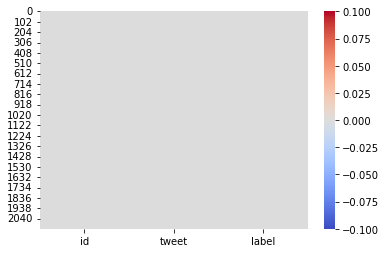

In [10]:
# plot a heatmap to show the presence of missing rows data in the testing set
sns.heatmap(c19_fake_news_df_test.isnull(), annot = False, cmap = "coolwarm")
plt.show()

#### 2.3 Remove irrelevant columns 

In [11]:
# remove irrelevant column in the training set
c19_fake_news_df_train.drop(columns = ['id'], axis = 1, inplace = True)

In [12]:
# remove irrelevant column in the testing set
c19_fake_news_df_test.drop(columns = ['id'], axis = 1, inplace = True)

#### 2.4 Text Cleaning 

In [13]:
# create a function to perform text cleaning 
def textCleaning(text):
    # transform the text into lower cases
    text = text.lower()
    
    # remove special characters and punctuations in the text
    text = re.sub(r"[^a-zA-Z]", " ", text)
    
    # remove digits in the text 
    text = re.sub(r"[\d]", " ", text)
    
    # tokenize the text
    tokenizedText = word_tokenize(text)
    
    # remove stopwords from the text
    filteredText = list()
    for word in tokenizedText:
        if word not in stopwords.words('english'):
            filteredText.append(word)
    
    # lemmatize the word 
    lemmatizeWords = list()
    lemmatizer = WordNetLemmatizer()
    for word in filteredText:
        lemmatizeWords.append(lemmatizer.lemmatize(word))
    
    # reform the tokenize words into text
    reformText = ' '.join(lemmatizeWords)
    
    return reformText

In [14]:
# call the function to perform text cleaning for training set
c19_fake_news_df_train['tweet'] = c19_fake_news_df_train['tweet'].apply(textCleaning)

In [15]:
c19_fake_news_df_train.head(20)

,tweet,label
0,cdc currently report death general discrepancy...,real
1,state reported death small rise last tuesday s...,real
2,politically correct woman almost us pandemic e...,fake
3,indiafightscorona covid testing laboratory ind...,real
4,populous state generate large case count look ...,real
5,covid act found average person illinois covid ...,real
6,tested positive covid symptom stay home away p...,real
7,obama call trump coronavirus response chaotic ...,fake
8,clearly obama administration leave kind game p...,fake
9,retraction hydroxychloroquine chloroquine with...,fake


In [16]:
# call the function to perform text cleaning for testing set
c19_fake_news_df_test['tweet'] = c19_fake_news_df_test['tweet'].apply(textCleaning)

In [17]:
c19_fake_news_df_test.head(20)

,tweet,label
0,chinese converting islam realising muslim affe...,fake
1,people diamond princess cruise ship intially t...,fake
2,covid caused bacterium virus treated aspirin,fake
3,mike penny rnc speech praise donald trump covi...,fake
4,sky edconwaysky explains latest covid data gov...,real
5,one leave managed isolation reason without ret...,real
6,indiafightscorona india one lowest covid morta...,real
7,rt covid transmission occurs primarily direct ...,real
8,news medium outlet abp majha basis internal me...,fake
9,church service resume vaccinated say bill gate,fake


#### 2.5 Encode Categorical Feature (Class Label) into Numerical Feature

In [18]:
# define the object of the label binarizer
lb = LabelBinarizer()
# fit and transform the class label from cat feature into num feature in the training set (i.e. fake = 0, real = 1)
c19_fake_news_df_train['label'] = lb.fit_transform(c19_fake_news_df_train['label'])

In [19]:
c19_fake_news_df_train.head()

,tweet,label
0,cdc currently report death general discrepancy...,1
1,state reported death small rise last tuesday s...,1
2,politically correct woman almost us pandemic e...,0
3,indiafightscorona covid testing laboratory ind...,1
4,populous state generate large case count look ...,1


In [20]:
# define the object of the label binarizer
lb = LabelBinarizer()
# fit and transform the class label from cat feature into num feature in the testing set (i.e. fake = 0, real = 1)
c19_fake_news_df_test['label'] = lb.fit_transform(c19_fake_news_df_test['label'])

In [21]:
c19_fake_news_df_test.head()

,tweet,label
0,chinese converting islam realising muslim affe...,0
1,people diamond princess cruise ship intially t...,0
2,covid caused bacterium virus treated aspirin,0
3,mike penny rnc speech praise donald trump covi...,0
4,sky edconwaysky explains latest covid data gov...,1


#### 2.6 Data Splitting

In [22]:
# split the training set into 80% training and 20% validation 
X_train, X_val, y_train, y_val = train_test_split(c19_fake_news_df_train['tweet'], 
                                                 c19_fake_news_df_train['label'],
                                                 test_size = 0.2, 
                                                 random_state = 42)

## 3. Model Building & Evaluation (Baseline)

In [23]:
# create a function to display the classification report
def displayClassificationReport(title, y_true, y_pred):
    print("Classification Report for", title)
    print(classification_report(y_true, y_pred, target_names = ['fake', 'real']))

In [24]:
# create a function to display roc curve
def displayROC(title, y_true, y_pred):
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    sns.set_style("darkgrid")
    sns.lineplot(x = fpr, y = tpr, color = "navy")
    sns.lineplot(x = [0, 1], y = [0, 1], color = "crimson")
    plt.title("ROC Curve for " + title, fontweight = 'bold', fontsize = 12)
    plt.xlabel("False Positive", fontweight = 'bold', fontsize = 12)
    plt.ylabel("True Positive", fontweight = 'bold', fontsize = 12)
    plt.show()

In [25]:
# create a function to display confusion matrix
def displayConfusionMatrix(title, y_true, y_pred):
    confusionMatrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(confusionMatrix, annot = True, cmap = "viridis")
    plt.title("Confusion Matrix for " + title, fontweight = 'bold', fontsize = 12)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()

#### 3.1 Multinomial NB

In [26]:
# create a pipeline steps
steps = [('tfidf_vectorize', TfidfVectorizer(analyzer = 'word')),
        ('smt', SMOTETomek(random_state = 42)),
        ('mnb_model', MultinomialNB())]

# build a pipeline
mnb_pipe = Pipeline(steps = steps)

# fit the model 
mnb_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf_vectorize', TfidfVectorizer()),
                ('smt', SMOTETomek(random_state=42)),
                ('mnb_model', MultinomialNB())])

In [27]:
# prediction on training set
y_pred_train_mnb = mnb_pipe.predict(X_train)
y_pred_proba_train_mnb = mnb_pipe.predict_proba(X_train)

# prediction on validation set
y_pred_val_mnb = mnb_pipe.predict(X_val)
y_pred_proba_val_mnb = mnb_pipe.predict_proba(X_val)

# prediction on testing set
y_pred_test_mnb = mnb_pipe.predict(c19_fake_news_df_test['tweet'])
y_pred_proba_test_mnb = mnb_pipe.predict_proba(c19_fake_news_df_test['tweet'])

In [28]:
# call the function to display the classification report
displayClassificationReport("Multinomial NB (training set)", y_train, y_pred_train_mnb)
print()
displayClassificationReport("Multinomial NB (validation set)", y_val, y_pred_val_mnb)
print()
displayClassificationReport("Multinomial NB (testing set)", c19_fake_news_df_test['label'], y_pred_test_mnb)

Classification Report for Multinomial NB (training set)
              precision    recall  f1-score   support

        fake       0.98      0.95      0.96      2464
        real       0.95      0.98      0.97      2672

    accuracy                           0.96      5136
   macro avg       0.96      0.96      0.96      5136
weighted avg       0.96      0.96      0.96      5136


Classification Report for Multinomial NB (validation set)
              precision    recall  f1-score   support

        fake       0.91      0.87      0.89       596
        real       0.89      0.93      0.91       688

    accuracy                           0.90      1284
   macro avg       0.90      0.90      0.90      1284
weighted avg       0.90      0.90      0.90      1284


Classification Report for Multinomial NB (testing set)
              precision    recall  f1-score   support

        fake       0.92      0.88      0.90      1020
        real       0.89      0.93      0.91      1120

    accurac

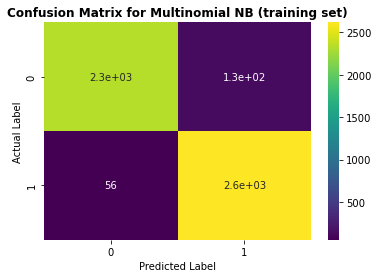

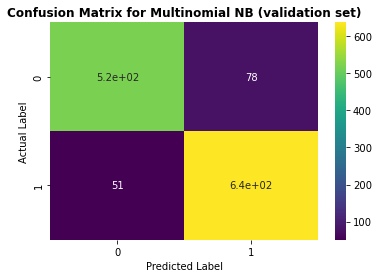

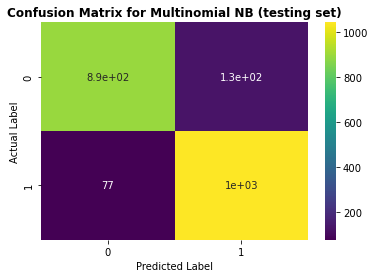

In [29]:
# call the function to display confusion matrix
displayConfusionMatrix("Multinomial NB (training set)", y_train, y_pred_train_mnb)
print()
displayConfusionMatrix("Multinomial NB (validation set)", y_val, y_pred_val_mnb)
print()
displayConfusionMatrix("Multinomial NB (testing set)", c19_fake_news_df_test['label'], y_pred_test_mnb)

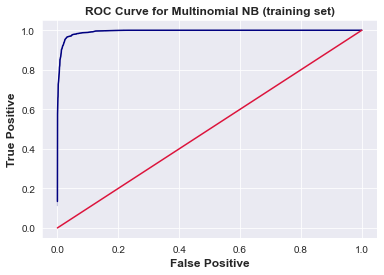

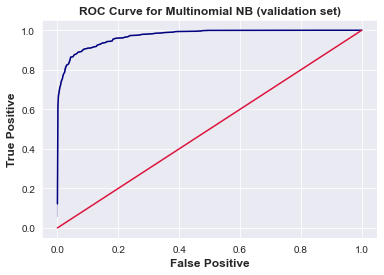

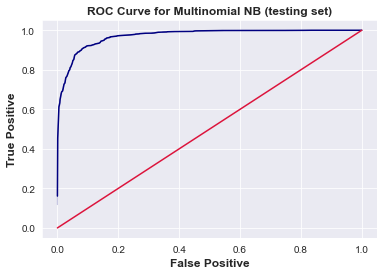

In [30]:
# call the function to display roc curve
displayROC("Multinomial NB (training set)", y_train, y_pred_proba_train_mnb[::,1])
print()
displayROC("Multinomial NB (validation set)", y_val, y_pred_proba_val_mnb[::,1])
print()
displayROC("Multinomial NB (testing set)", c19_fake_news_df_test['label'], y_pred_proba_test_mnb[::, 1])

#### 3.2 Logistic Regression

In [31]:
# create a pipeline steps
steps = [('tfidf_vectorize', TfidfVectorizer(analyzer = 'word')),
        ('smt', SMOTETomek(random_state = 42)),
        ('lr', LogisticRegression(random_state = 42))]

# build a pipeline
lr_pipe = Pipeline(steps = steps)

# fit the model 
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf_vectorize', TfidfVectorizer()),
                ('smt', SMOTETomek(random_state=42)),
                ('lr', LogisticRegression(random_state=42))])

In [32]:
# prediction on training set
y_pred_train_lr = lr_pipe.predict(X_train)
y_pred_proba_train_lr = lr_pipe.predict_proba(X_train)

# prediction on validation set
y_pred_val_lr = lr_pipe.predict(X_val)
y_pred_proba_val_lr = lr_pipe.predict_proba(X_val)

# prediction on testing set
y_pred_test_lr = lr_pipe.predict(c19_fake_news_df_test['tweet'])
y_pred_proba_test_lr = lr_pipe.predict_proba(c19_fake_news_df_test['tweet'])


In [33]:
# call the function to display the classification report
displayClassificationReport("Logistic Regression (training set)", y_train, y_pred_train_lr)
print()
displayClassificationReport("Logistic Regression (validation set)", y_val, y_pred_val_lr)
print()
displayClassificationReport("Logistic Regression (testing set)", c19_fake_news_df_test['label'], y_pred_test_lr)

Classification Report for Logistic Regression (training set)
              precision    recall  f1-score   support

        fake       0.96      0.97      0.97      2464
        real       0.98      0.97      0.97      2672

    accuracy                           0.97      5136
   macro avg       0.97      0.97      0.97      5136
weighted avg       0.97      0.97      0.97      5136


Classification Report for Logistic Regression (validation set)
              precision    recall  f1-score   support

        fake       0.92      0.91      0.91       596
        real       0.92      0.93      0.93       688

    accuracy                           0.92      1284
   macro avg       0.92      0.92      0.92      1284
weighted avg       0.92      0.92      0.92      1284


Classification Report for Logistic Regression (testing set)
              precision    recall  f1-score   support

        fake       0.92      0.90      0.91      1020
        real       0.91      0.93      0.92      11

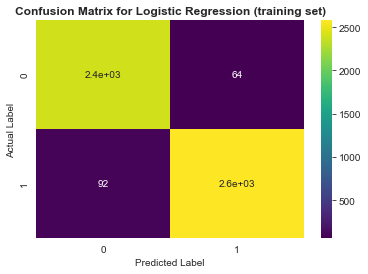

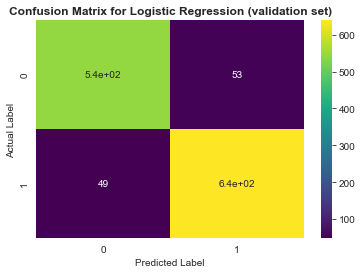

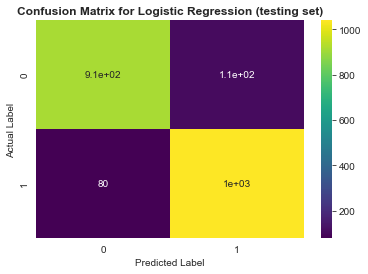

In [34]:
# call the function to display the confusion matrix
displayConfusionMatrix("Logistic Regression (training set)", y_train, y_pred_train_lr)
print()
displayConfusionMatrix("Logistic Regression (validation set)", y_val, y_pred_val_lr)
print()
displayConfusionMatrix("Logistic Regression (testing set)", c19_fake_news_df_test['label'], y_pred_test_lr)

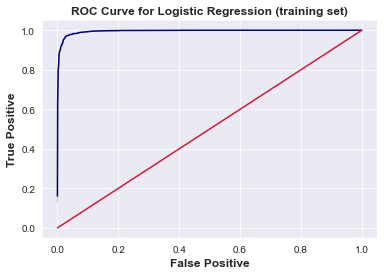

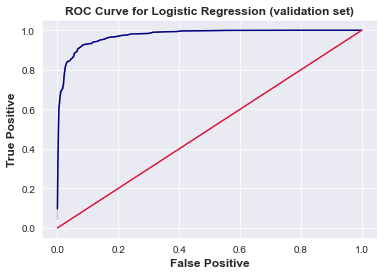

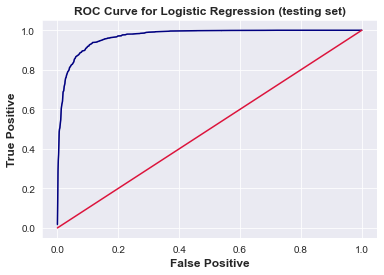

In [35]:
# call the function to display the roc curve
displayROC("Logistic Regression (training set)", y_train, y_pred_proba_train_lr[::, 1])
print()
displayROC("Logistic Regression (validation set)", y_val, y_pred_proba_val_lr[::, 1])
print()
displayROC("Logistic Regression (testing set)", c19_fake_news_df_test['label'], y_pred_proba_test_lr[::, 1])


#### 3.3 Random Forest Classifier

In [36]:
# create a pipeline steps
steps = [('tfidf_vectorize', TfidfVectorizer(analyzer = 'word')),
        ('smt', SMOTETomek(random_state = 42)),
        ('rfc', RandomForestClassifier(random_state = 42))]

# build a pipeline
rfc_pipe = Pipeline(steps = steps)

# fit the model 
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf_vectorize', TfidfVectorizer()),
                ('smt', SMOTETomek(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [37]:
# prediction on training set
y_pred_train_rfc = rfc_pipe.predict(X_train)
y_pred_proba_train_rfc = rfc_pipe.predict_proba(X_train)

# prediction on validation set
y_pred_val_rfc = rfc_pipe.predict(X_val)
y_pred_proba_val_rfc = rfc_pipe.predict_proba(X_val)

# prediction on testing set
y_pred_test_rfc = rfc_pipe.predict(c19_fake_news_df_test['tweet'])
y_pred_proba_test_rfc = rfc_pipe.predict_proba(c19_fake_news_df_test['tweet'])

In [38]:
# call the function to display the classification report
displayClassificationReport("Random Forest Classifier (training set)", y_train, y_pred_train_rfc)
print()
displayClassificationReport("Random Forest Classifier (validation set)", y_val, y_pred_val_rfc)
print()
displayClassificationReport("Random Forest Classifier (testing set)", c19_fake_news_df_test['label'], y_pred_test_rfc)

Classification Report for Random Forest Classifier (training set)
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00      2464
        real       1.00      1.00      1.00      2672

    accuracy                           1.00      5136
   macro avg       1.00      1.00      1.00      5136
weighted avg       1.00      1.00      1.00      5136


Classification Report for Random Forest Classifier (validation set)
              precision    recall  f1-score   support

        fake       0.92      0.92      0.92       596
        real       0.93      0.93      0.93       688

    accuracy                           0.93      1284
   macro avg       0.93      0.93      0.93      1284
weighted avg       0.93      0.93      0.93      1284


Classification Report for Random Forest Classifier (testing set)
              precision    recall  f1-score   support

        fake       0.92      0.91      0.92      1020
        real       0.92      0.93   

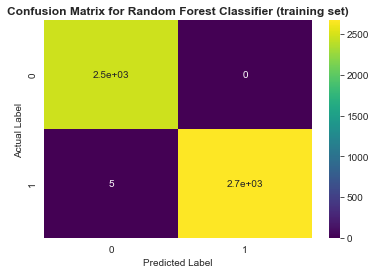

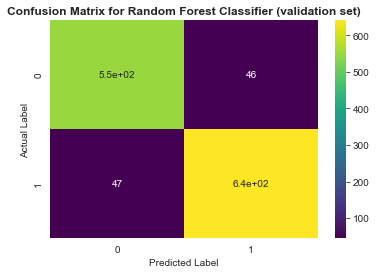

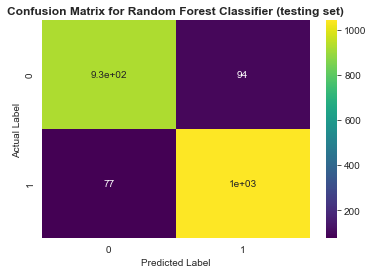

In [39]:
# call the function to display the confusion matrix
displayConfusionMatrix("Random Forest Classifier (training set)", y_train, y_pred_train_rfc)
print()
displayConfusionMatrix("Random Forest Classifier (validation set)", y_val, y_pred_val_rfc)
print()
displayConfusionMatrix("Random Forest Classifier (testing set)", c19_fake_news_df_test['label'], y_pred_test_rfc)

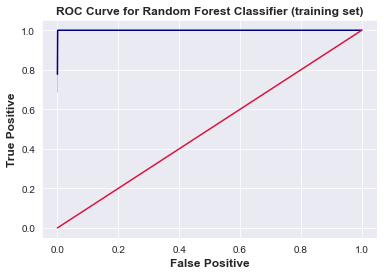

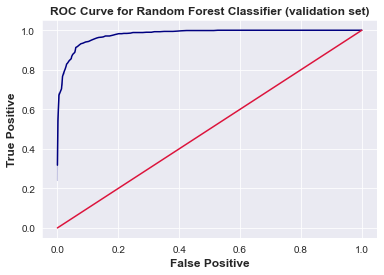

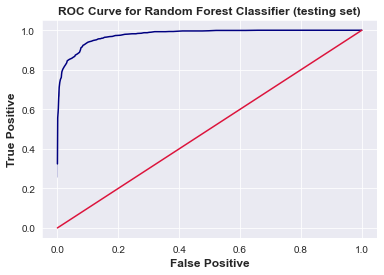

In [40]:
# call the function to display the confusion matrix
displayROC("Random Forest Classifier (training set)", y_train, y_pred_proba_train_rfc[::,1])
print()
displayROC("Random Forest Classifier (validation set)", y_val, y_pred_proba_val_rfc[::,1])
print()
displayROC("Random Forest Classifier (testing set)", c19_fake_news_df_test['label'], y_pred_proba_test_rfc[::,1])

## 4. Hyperparameters Tuning 

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [42]:
def grid_searchCV(model, params):
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 42)
    gridSearch = GridSearchCV(model, cv = cv, param_grid = params, verbose = 3, scoring = 'accuracy', return_train_score = True, n_jobs = 1)
    gridSearch.fit(X_train, y_train)
    return gridSearch

#### 4.1 Multinomial NB

In [43]:
# create a pipeline steps
steps = [('tfidf_vectorize', TfidfVectorizer(analyzer = 'word')),
        ('smt', SMOTETomek(random_state = 42)),
        ('mnb_model', MultinomialNB())]

# build a pipeline
mnb_pipe = Pipeline(steps = steps)

# define grid params 
mnb_params = {'mnb_model__alpha': [0.01, 0.1, 1, 10, 100]}

In [44]:
# call the function to perform grid search on multinomial nb 
grid_mnb = grid_searchCV(mnb_pipe, mnb_params)

Fitting 15 folds for each of 5 candidates, totalling 75 fits
[CV 1/15] END mnb_model__alpha=0.01;, score=(train=0.992, test=0.926) total time=   0.4s
[CV 2/15] END mnb_model__alpha=0.01;, score=(train=0.994, test=0.923) total time=   0.4s
[CV 3/15] END mnb_model__alpha=0.01;, score=(train=0.992, test=0.908) total time=   0.4s
[CV 4/15] END mnb_model__alpha=0.01;, score=(train=0.994, test=0.899) total time=   0.4s
[CV 5/15] END mnb_model__alpha=0.01;, score=(train=0.992, test=0.911) total time=   0.4s
[CV 6/15] END mnb_model__alpha=0.01;, score=(train=0.994, test=0.914) total time=   0.4s
[CV 7/15] END mnb_model__alpha=0.01;, score=(train=0.994, test=0.906) total time=   0.4s
[CV 8/15] END mnb_model__alpha=0.01;, score=(train=0.993, test=0.923) total time=   0.4s
[CV 9/15] END mnb_model__alpha=0.01;, score=(train=0.993, test=0.919) total time=   0.4s
[CV 10/15] END mnb_model__alpha=0.01;, score=(train=0.994, test=0.907) total time=   0.4s
[CV 11/15] END mnb_model__alpha=0.01;, score=(tr

In [45]:
# display the best params and best scores
print("Best Score: ", grid_mnb.best_score_)
print("Best Hyperparameters: ", grid_mnb.best_params_)

Best Score:  0.9169896579638981
Best Hyperparameters:  {'mnb_model__alpha': 0.1}


#### 4.2 Logistic Regression

In [46]:
# create a pipeline steps
steps = [('tfidf_vectorize', TfidfVectorizer(analyzer = 'word')),
        ('smt', SMOTETomek(random_state = 42)),
        ('lr', LogisticRegression(random_state = 42))]

# build a pipeline
lr_pipe = Pipeline(steps = steps)

# define grid params
lr_params = {'lr__C': [0.1, 1, 2, 5, 10, 15, 20]}

In [47]:
# call the function to perform grid search on logistic regression 
grid_lr = grid_searchCV(lr_pipe, lr_params)

Fitting 15 folds for each of 7 candidates, totalling 105 fits
[CV 1/15] END ....lr__C=0.1;, score=(train=0.902, test=0.880) total time=   0.4s
[CV 2/15] END ....lr__C=0.1;, score=(train=0.898, test=0.886) total time=   0.5s
[CV 3/15] END ....lr__C=0.1;, score=(train=0.902, test=0.860) total time=   0.5s
[CV 4/15] END ....lr__C=0.1;, score=(train=0.903, test=0.879) total time=   0.5s
[CV 5/15] END ....lr__C=0.1;, score=(train=0.897, test=0.886) total time=   0.5s
[CV 6/15] END ....lr__C=0.1;, score=(train=0.904, test=0.876) total time=   0.5s
[CV 7/15] END ....lr__C=0.1;, score=(train=0.900, test=0.870) total time=   0.5s
[CV 8/15] END ....lr__C=0.1;, score=(train=0.899, test=0.895) total time=   0.5s
[CV 9/15] END ....lr__C=0.1;, score=(train=0.901, test=0.877) total time=   0.4s
[CV 10/15] END ...lr__C=0.1;, score=(train=0.899, test=0.871) total time=   0.5s
[CV 11/15] END ...lr__C=0.1;, score=(train=0.896, test=0.896) total time=   0.5s
[CV 12/15] END ...lr__C=0.1;, score=(train=0.90

[CV 12/15] END ....lr__C=20;, score=(train=0.999, test=0.925) total time=   0.6s
[CV 13/15] END ....lr__C=20;, score=(train=0.999, test=0.915) total time=   0.6s
[CV 14/15] END ....lr__C=20;, score=(train=0.999, test=0.941) total time=   0.6s
[CV 15/15] END ....lr__C=20;, score=(train=0.999, test=0.927) total time=   0.5s


In [48]:
# display the best params and best scores
print("Best Score: ", grid_lr.best_score_)
print("Best Hyperparameters: ", grid_lr.best_params_)

Best Score:  0.9310734677330748
Best Hyperparameters:  {'lr__C': 20}


#### 4.3 Random Forest Classifier

In [49]:
# create a pipeline steps
steps = [('tfidf_vectorize', TfidfVectorizer(analyzer = 'word')),
        ('smt', SMOTETomek(random_state = 42)),
        ('rfc', RandomForestClassifier(random_state = 42))]

# build a pipeline
rfc_pipe = Pipeline(steps = steps)

# define params grid
rfc_params = {'rfc__n_estimators': [100, 200, 300, 400, 500], 
         'rfc__max_depth': [3, 5, 7, 9, 11]}

In [50]:
# call the function to perform grid search on logistic regression 
grid_rfc = grid_searchCV(rfc_pipe, rfc_params)

Fitting 15 folds for each of 25 candidates, totalling 375 fits
[CV 1/15] END rfc__max_depth=3, rfc__n_estimators=100;, score=(train=0.835, test=0.832) total time=   0.6s
[CV 2/15] END rfc__max_depth=3, rfc__n_estimators=100;, score=(train=0.839, test=0.828) total time=   0.6s
[CV 3/15] END rfc__max_depth=3, rfc__n_estimators=100;, score=(train=0.847, test=0.817) total time=   0.6s
[CV 4/15] END rfc__max_depth=3, rfc__n_estimators=100;, score=(train=0.865, test=0.868) total time=   0.6s
[CV 5/15] END rfc__max_depth=3, rfc__n_estimators=100;, score=(train=0.847, test=0.839) total time=   0.6s
[CV 6/15] END rfc__max_depth=3, rfc__n_estimators=100;, score=(train=0.841, test=0.830) total time=   0.6s
[CV 7/15] END rfc__max_depth=3, rfc__n_estimators=100;, score=(train=0.859, test=0.853) total time=   0.6s
[CV 8/15] END rfc__max_depth=3, rfc__n_estimators=100;, score=(train=0.834, test=0.835) total time=   0.6s
[CV 9/15] END rfc__max_depth=3, rfc__n_estimators=100;, score=(train=0.857, test=

[CV 2/15] END rfc__max_depth=5, rfc__n_estimators=100;, score=(train=0.847, test=0.833) total time=   0.6s
[CV 3/15] END rfc__max_depth=5, rfc__n_estimators=100;, score=(train=0.863, test=0.833) total time=   0.6s
[CV 4/15] END rfc__max_depth=5, rfc__n_estimators=100;, score=(train=0.874, test=0.863) total time=   0.6s
[CV 5/15] END rfc__max_depth=5, rfc__n_estimators=100;, score=(train=0.859, test=0.847) total time=   0.6s
[CV 6/15] END rfc__max_depth=5, rfc__n_estimators=100;, score=(train=0.855, test=0.843) total time=   0.6s
[CV 7/15] END rfc__max_depth=5, rfc__n_estimators=100;, score=(train=0.855, test=0.839) total time=   0.6s
[CV 8/15] END rfc__max_depth=5, rfc__n_estimators=100;, score=(train=0.843, test=0.844) total time=   0.6s
[CV 9/15] END rfc__max_depth=5, rfc__n_estimators=100;, score=(train=0.872, test=0.837) total time=   0.6s
[CV 10/15] END rfc__max_depth=5, rfc__n_estimators=100;, score=(train=0.853, test=0.834) total time=   0.6s
[CV 11/15] END rfc__max_depth=5, rfc

[CV 4/15] END rfc__max_depth=7, rfc__n_estimators=100;, score=(train=0.882, test=0.874) total time=   0.6s
[CV 5/15] END rfc__max_depth=7, rfc__n_estimators=100;, score=(train=0.864, test=0.860) total time=   0.6s
[CV 6/15] END rfc__max_depth=7, rfc__n_estimators=100;, score=(train=0.873, test=0.863) total time=   0.6s
[CV 7/15] END rfc__max_depth=7, rfc__n_estimators=100;, score=(train=0.862, test=0.842) total time=   0.6s
[CV 8/15] END rfc__max_depth=7, rfc__n_estimators=100;, score=(train=0.853, test=0.857) total time=   0.6s
[CV 9/15] END rfc__max_depth=7, rfc__n_estimators=100;, score=(train=0.882, test=0.846) total time=   0.7s
[CV 10/15] END rfc__max_depth=7, rfc__n_estimators=100;, score=(train=0.878, test=0.853) total time=   0.6s
[CV 11/15] END rfc__max_depth=7, rfc__n_estimators=100;, score=(train=0.866, test=0.852) total time=   0.6s
[CV 12/15] END rfc__max_depth=7, rfc__n_estimators=100;, score=(train=0.873, test=0.841) total time=   0.6s
[CV 13/15] END rfc__max_depth=7, r

[CV 6/15] END rfc__max_depth=9, rfc__n_estimators=100;, score=(train=0.885, test=0.862) total time=   0.7s
[CV 7/15] END rfc__max_depth=9, rfc__n_estimators=100;, score=(train=0.873, test=0.846) total time=   0.7s
[CV 8/15] END rfc__max_depth=9, rfc__n_estimators=100;, score=(train=0.871, test=0.866) total time=   0.6s
[CV 9/15] END rfc__max_depth=9, rfc__n_estimators=100;, score=(train=0.884, test=0.843) total time=   0.7s
[CV 10/15] END rfc__max_depth=9, rfc__n_estimators=100;, score=(train=0.889, test=0.860) total time=   0.7s
[CV 11/15] END rfc__max_depth=9, rfc__n_estimators=100;, score=(train=0.878, test=0.860) total time=   0.7s
[CV 12/15] END rfc__max_depth=9, rfc__n_estimators=100;, score=(train=0.884, test=0.858) total time=   0.7s
[CV 13/15] END rfc__max_depth=9, rfc__n_estimators=100;, score=(train=0.876, test=0.835) total time=   0.7s
[CV 14/15] END rfc__max_depth=9, rfc__n_estimators=100;, score=(train=0.878, test=0.854) total time=   0.6s
[CV 15/15] END rfc__max_depth=9,

[CV 8/15] END rfc__max_depth=11, rfc__n_estimators=100;, score=(train=0.883, test=0.866) total time=   0.7s
[CV 9/15] END rfc__max_depth=11, rfc__n_estimators=100;, score=(train=0.897, test=0.853) total time=   0.7s
[CV 10/15] END rfc__max_depth=11, rfc__n_estimators=100;, score=(train=0.897, test=0.863) total time=   0.7s
[CV 11/15] END rfc__max_depth=11, rfc__n_estimators=100;, score=(train=0.888, test=0.865) total time=   0.7s
[CV 12/15] END rfc__max_depth=11, rfc__n_estimators=100;, score=(train=0.890, test=0.860) total time=   0.7s
[CV 13/15] END rfc__max_depth=11, rfc__n_estimators=100;, score=(train=0.891, test=0.848) total time=   0.7s
[CV 14/15] END rfc__max_depth=11, rfc__n_estimators=100;, score=(train=0.887, test=0.865) total time=   0.7s
[CV 15/15] END rfc__max_depth=11, rfc__n_estimators=100;, score=(train=0.894, test=0.870) total time=   0.7s
[CV 1/15] END rfc__max_depth=11, rfc__n_estimators=200;, score=(train=0.892, test=0.866) total time=   1.0s
[CV 2/15] END rfc__max

In [51]:
# display the best params and best scores
print("Best Score: ", grid_rfc.best_score_)
print("Best Hyperparameters: ", grid_rfc.best_params_)

Best Score:  0.8661737497426804
Best Hyperparameters:  {'rfc__max_depth': 11, 'rfc__n_estimators': 500}


## 5. Rebuild Model and Model Evaluation

#### 5.1 Multinomial NB

In [52]:
# create a pipeline steps
steps = [('tfidf_vectorize', TfidfVectorizer(analyzer = 'word')),
        ('smt', SMOTETomek(random_state = 42)),
        ('mnb_model', MultinomialNB(alpha=0.1))]

# build a pipeline
mnb_pipe2 = Pipeline(steps = steps)

# fit the model 
mnb_pipe2.fit(X_train, y_train)

Pipeline(steps=[('tfidf_vectorize', TfidfVectorizer()),
                ('smt', SMOTETomek(random_state=42)),
                ('mnb_model', MultinomialNB(alpha=0.1))])

In [53]:
# prediction on training set
y_pred_train_mnb2 = mnb_pipe2.predict(X_train)
y_pred_proba_train_mnb2 = mnb_pipe2.predict_proba(X_train)

# prediction on validation set
y_pred_val_mnb2 = mnb_pipe2.predict(X_val)
y_pred_proba_val_mnb2 = mnb_pipe2.predict_proba(X_val)

# prediction on testing set
y_pred_test_mnb2 = mnb_pipe2.predict(c19_fake_news_df_test['tweet'])
y_pred_proba_test_mnb2 = mnb_pipe2.predict_proba(c19_fake_news_df_test['tweet'])

In [54]:
# call the function to display the classification report
displayClassificationReport("Multinomial NB (training set)", y_train, y_pred_train_mnb2)
print()
displayClassificationReport("Multinomial NB (validation set)", y_val, y_pred_val_mnb2)
print()
displayClassificationReport("Multinomial NB (testing set)", c19_fake_news_df_test['label'], y_pred_test_mnb2)

Classification Report for Multinomial NB (training set)
              precision    recall  f1-score   support

        fake       0.99      0.98      0.99      2464
        real       0.98      0.99      0.99      2672

    accuracy                           0.99      5136
   macro avg       0.99      0.99      0.99      5136
weighted avg       0.99      0.99      0.99      5136


Classification Report for Multinomial NB (validation set)
              precision    recall  f1-score   support

        fake       0.89      0.90      0.90       596
        real       0.91      0.91      0.91       688

    accuracy                           0.90      1284
   macro avg       0.90      0.90      0.90      1284
weighted avg       0.90      0.90      0.90      1284


Classification Report for Multinomial NB (testing set)
              precision    recall  f1-score   support

        fake       0.92      0.91      0.91      1020
        real       0.92      0.92      0.92      1120

    accurac

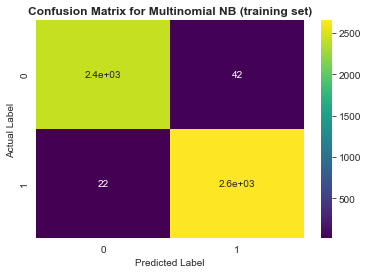

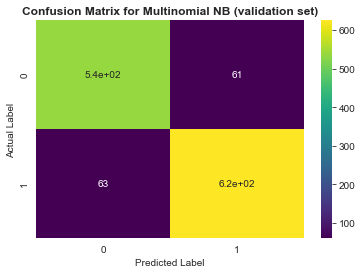

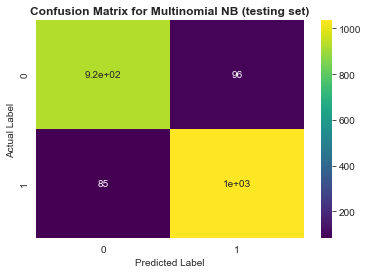

In [55]:
# call the function to display confusion matrix
displayConfusionMatrix("Multinomial NB (training set)", y_train, y_pred_train_mnb2)
print()
displayConfusionMatrix("Multinomial NB (validation set)", y_val, y_pred_val_mnb2)
print()
displayConfusionMatrix("Multinomial NB (testing set)", c19_fake_news_df_test['label'], y_pred_test_mnb2)

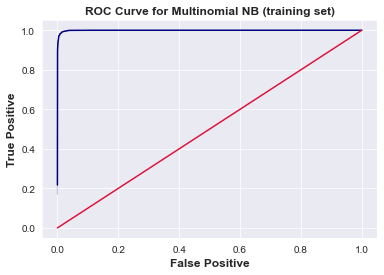

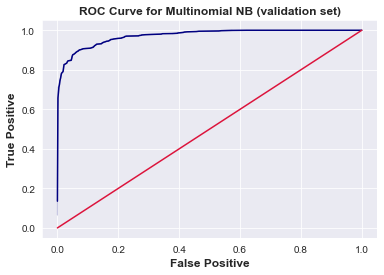

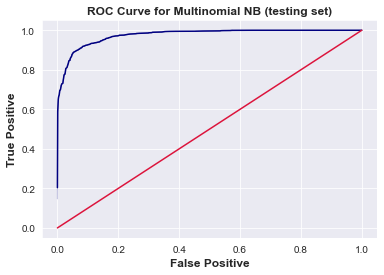

In [56]:
# call the function to display roc curve
displayROC("Multinomial NB (training set)", y_train, y_pred_proba_train_mnb2[::,1])
print()
displayROC("Multinomial NB (validation set)", y_val, y_pred_proba_val_mnb2[::,1])
print()
displayROC("Multinomial NB (testing set)", c19_fake_news_df_test['label'], y_pred_proba_test_mnb2[::, 1])

#### 5.2 Logistic Regression

In [57]:
# create a pipeline steps
steps = [('tfidf_vectorize', TfidfVectorizer(analyzer = 'word')),
        ('smt', SMOTETomek(random_state = 42)),
        ('lr', LogisticRegression(C=20, random_state = 42))]

# build a pipeline
lr_pipe2 = Pipeline(steps = steps)

# fit the model 
lr_pipe2.fit(X_train, y_train)

Pipeline(steps=[('tfidf_vectorize', TfidfVectorizer()),
                ('smt', SMOTETomek(random_state=42)),
                ('lr', LogisticRegression(C=20, random_state=42))])

In [58]:
# prediction on training set
y_pred_train_lr2 = lr_pipe2.predict(X_train)
y_pred_proba_train_lr2 = lr_pipe2.predict_proba(X_train)

# prediction on validation set
y_pred_val_lr2 = lr_pipe2.predict(X_val)
y_pred_proba_val_lr2 = lr_pipe2.predict_proba(X_val)

# prediction on testing set
y_pred_test_lr2 = lr_pipe2.predict(c19_fake_news_df_test['tweet'])
y_pred_proba_test_lr2 = lr_pipe2.predict_proba(c19_fake_news_df_test['tweet'])


In [60]:
# call the function to display the classification report
displayClassificationReport("Logistic Regression (training set)", y_train, y_pred_train_lr2)
print()
displayClassificationReport("Logistic Regression (validation set)", y_val, y_pred_val_lr2)
print()
displayClassificationReport("Logistic Regression (testing set)", c19_fake_news_df_test['label'], y_pred_test_lr2)

Classification Report for Logistic Regression (training set)
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00      2464
        real       1.00      1.00      1.00      2672

    accuracy                           1.00      5136
   macro avg       1.00      1.00      1.00      5136
weighted avg       1.00      1.00      1.00      5136


Classification Report for Logistic Regression (validation set)
              precision    recall  f1-score   support

        fake       0.93      0.92      0.92       596
        real       0.93      0.94      0.94       688

    accuracy                           0.93      1284
   macro avg       0.93      0.93      0.93      1284
weighted avg       0.93      0.93      0.93      1284


Classification Report for Logistic Regression (testing set)
              precision    recall  f1-score   support

        fake       0.93      0.90      0.92      1020
        real       0.91      0.94      0.93      11

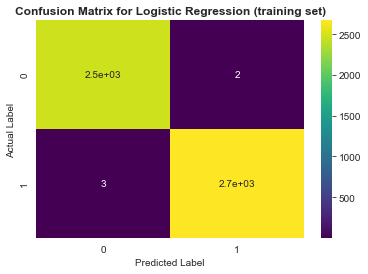

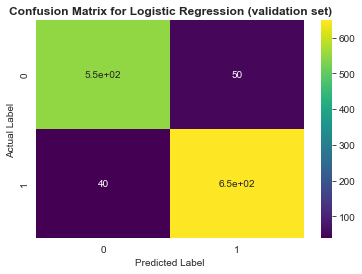

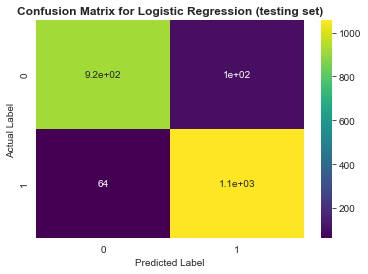

In [59]:
# call the function to display the confusion matrix
displayConfusionMatrix("Logistic Regression (training set)", y_train, y_pred_train_lr2)
print()
displayConfusionMatrix("Logistic Regression (validation set)", y_val, y_pred_val_lr2)
print()
displayConfusionMatrix("Logistic Regression (testing set)", c19_fake_news_df_test['label'], y_pred_test_lr2)

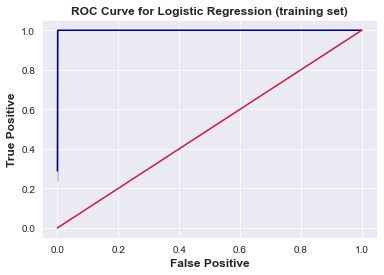

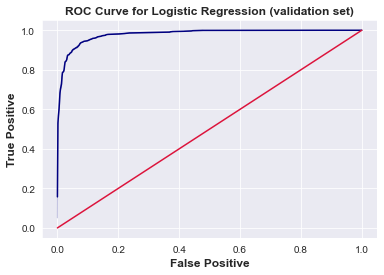

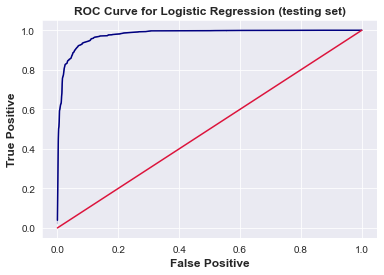

In [61]:
# call the function to display the roc curve
displayROC("Logistic Regression (training set)", y_train, y_pred_proba_train_lr2[::, 1])
print()
displayROC("Logistic Regression (validation set)", y_val, y_pred_proba_val_lr2[::, 1])
print()
displayROC("Logistic Regression (testing set)", c19_fake_news_df_test['label'], y_pred_proba_test_lr2[::, 1])


#### 5.3 Random Forest Classifier

In [62]:
# create a pipeline steps
steps = [('tfidf_vectorize', TfidfVectorizer(analyzer = 'word')),
        ('smt', SMOTETomek(random_state = 42)),
        ('rfc', RandomForestClassifier(n_estimators = 500, max_depth = 11, random_state = 42))]

# build a pipeline
rfc_pipe2 = Pipeline(steps = steps)

# fit the model 
rfc_pipe2.fit(X_train, y_train)

Pipeline(steps=[('tfidf_vectorize', TfidfVectorizer()),
                ('smt', SMOTETomek(random_state=42)),
                ('rfc',
                 RandomForestClassifier(max_depth=11, n_estimators=500,
                                        random_state=42))])

In [63]:
# prediction on training set
y_pred_train_rfc2 = rfc_pipe2.predict(X_train)
y_pred_proba_train_rfc2 = rfc_pipe2.predict_proba(X_train)

# prediction on validation set
y_pred_val_rfc2 = rfc_pipe2.predict(X_val)
y_pred_proba_val_rfc2 = rfc_pipe2.predict_proba(X_val)

# prediction on testing set
y_pred_test_rfc2 = rfc_pipe2.predict(c19_fake_news_df_test['tweet'])
y_pred_proba_test_rfc2 = rfc_pipe2.predict_proba(c19_fake_news_df_test['tweet'])

In [64]:
# call the function to display the classification report
displayClassificationReport("Random Forest Classifier (training set)", y_train, y_pred_train_rfc2)
print()
displayClassificationReport("Random Forest Classifier (validation set)", y_val, y_pred_val_rfc2)
print()
displayClassificationReport("Random Forest Classifier (testing set)", c19_fake_news_df_test['label'], y_pred_test_rfc2)

Classification Report for Random Forest Classifier (training set)
              precision    recall  f1-score   support

        fake       0.84      0.97      0.90      2464
        real       0.97      0.83      0.90      2672

    accuracy                           0.90      5136
   macro avg       0.91      0.90      0.90      5136
weighted avg       0.91      0.90      0.90      5136


Classification Report for Random Forest Classifier (validation set)
              precision    recall  f1-score   support

        fake       0.82      0.94      0.88       596
        real       0.94      0.82      0.88       688

    accuracy                           0.88      1284
   macro avg       0.88      0.88      0.88      1284
weighted avg       0.89      0.88      0.88      1284


Classification Report for Random Forest Classifier (testing set)
              precision    recall  f1-score   support

        fake       0.83      0.93      0.88      1020
        real       0.93      0.83   

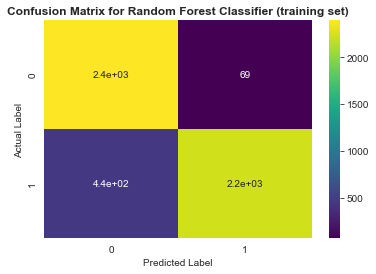

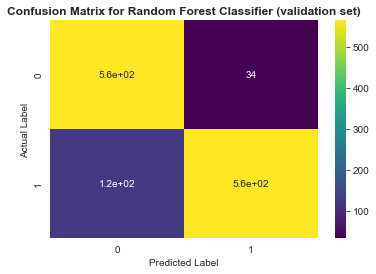

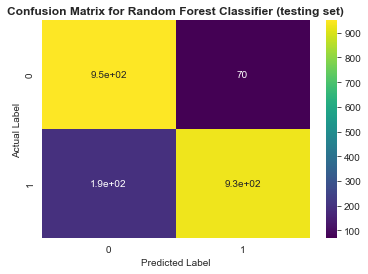

In [65]:
# call the function to display the confusion matrix
displayConfusionMatrix("Random Forest Classifier (training set)", y_train, y_pred_train_rfc2)
print()
displayConfusionMatrix("Random Forest Classifier (validation set)", y_val, y_pred_val_rfc2)
print()
displayConfusionMatrix("Random Forest Classifier (testing set)", c19_fake_news_df_test['label'], y_pred_test_rfc2)

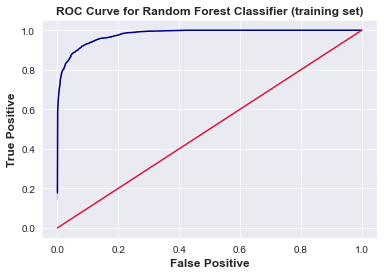

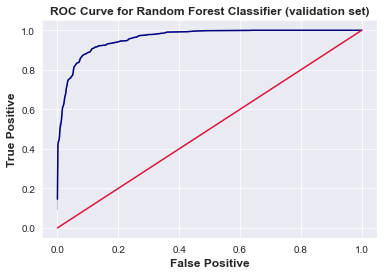

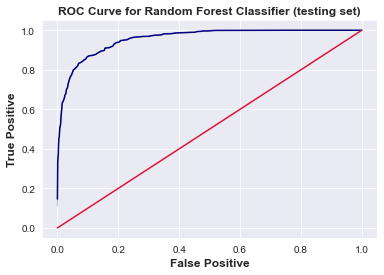

In [66]:
# call the function to display the confusion matrix
displayROC("Random Forest Classifier (training set)", y_train, y_pred_proba_train_rfc2[::,1])
print()
displayROC("Random Forest Classifier (validation set)", y_val, y_pred_proba_val_rfc2[::,1])
print()
displayROC("Random Forest Classifier (testing set)", c19_fake_news_df_test['label'], y_pred_proba_test_rfc2[::,1])

## 6. Model Savings

In [67]:
import pickle

In [70]:
# create a function to save the model 
def saveModel(filepath, model):
    return pickle.dump(model, open(filepath, 'wb'))

In [71]:
# create a model list
modelList = [mnb_pipe2, lr_pipe2, rfc_pipe2]
# create a filepath list
filepathList = ['mnb_model.sav', 'lr_model.sav', 'rfc_model.sav']

# call the function to save the respective model
for i in range(len(model_list)):
    saveModel(filepathList[i], modelList[i])

In [72]:
# create a function to load the model
def loadModel(filepath):
    print(pickle.load(open(filepath, 'rb')))
    

In [73]:
# call the function to open the respective model
for i in range(len(model_list)):
    loadModel(filepathList[i])

Pipeline(steps=[('tfidf_vectorize', TfidfVectorizer()),
                ('smt', SMOTETomek(random_state=42)),
                ('mnb_model', MultinomialNB(alpha=0.1))])
Pipeline(steps=[('tfidf_vectorize', TfidfVectorizer()),
                ('smt', SMOTETomek(random_state=42)),
                ('lr', LogisticRegression(C=20, random_state=42))])
Pipeline(steps=[('tfidf_vectorize', TfidfVectorizer()),
                ('smt', SMOTETomek(random_state=42)),
                ('rfc',
                 RandomForestClassifier(max_depth=11, n_estimators=500,
                                        random_state=42))])
